In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from keras import backend as K
K.set_image_data_format('channels_last')

**PatchGAN Discriminator**

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, LeakyReLU, Activation, Concatenate, BatchNormalization, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

def define_discriminator(input_shape_2d, output_shape_3d):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # source image input (2D brightfield)
    in_src_image = Input(shape=input_shape_2d)
    
    # target image input (3D fluorescence)
    in_target_image = Input(shape=output_shape_3d)
    


    
    # Expanding dimensions of source image to match target image
    expanded_src = Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          output_shape=lambda input_shape: input_shape + (1,))(in_src_image)

    expanded_src = Lambda(lambda x: tf.tile(x, [1, 1, 1, 1, output_shape_3d[-1]]),
                          output_shape=lambda input_shape: input_shape[:-1] + (output_shape_3d[-1],))(expanded_src)

    expanded_src = Reshape((input_shape_2d[0], input_shape_2d[1], output_shape_3d[-1]))(expanded_src)

    # concatenating images channel-wise
    merged = Concatenate(axis=-1)([expanded_src, in_target_image])
    
    # Reshaping merged tensor to 5D for Conv3D
    merged = Reshape((128, 128, output_shape_3d[-1] * 2, 1))(merged)
    
    # C64
    d = Conv3D(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C128
    d = Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # second last output layer
    d = Conv3D(512, (4,4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # patch output
    d = Conv3D(1, (4,4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
    # model
    model = Model([in_src_image, in_target_image], patch_out)
    
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

# image shapes
input_shape_2d = (128, 128, 1)  # 2D brightfield image
output_shape_3d = (128, 128, 6)  # 3D fluorescence image with 6 channels


model = define_discriminator(input_shape_2d, output_shape_3d)


model.summary()


2024-09-02 11:28:13.301592: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-09-02 11:28:13.301610: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-09-02 11:28:13.301616: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-09-02 11:28:13.301634: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-02 11:28:13.301644: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope`

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 1, 1)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ lambda[0][0]      │
│                     │ 1, 6)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 128,  │          0 │ lambda_1[0][0]    │
│                     │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ reshape[0][0],    │
│ (Concatenate)       │ 12)               │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 128, 128,  │          0 │ concatenate[0][0] │
│                     │ 12, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 64, 64, 6, │      4,160 │ reshape_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64, 6, │          0 │ conv3d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 32, 32, 3, │    524,416 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32, 3, │        512 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32, 3, │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 16, 16, 2, │  2,097,408 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16, 2, │      1,024 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16, 2, │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 8, 8, 1,   │  8,389,120 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 1,   │      2,048 │ conv3d_3[0][0]  

 Total params: 27,831,233 (106.17 MB)

 Trainable params: 27,828,417 (106.16 MB)

 Non-trainable params: 2,816 (11.00 KB)

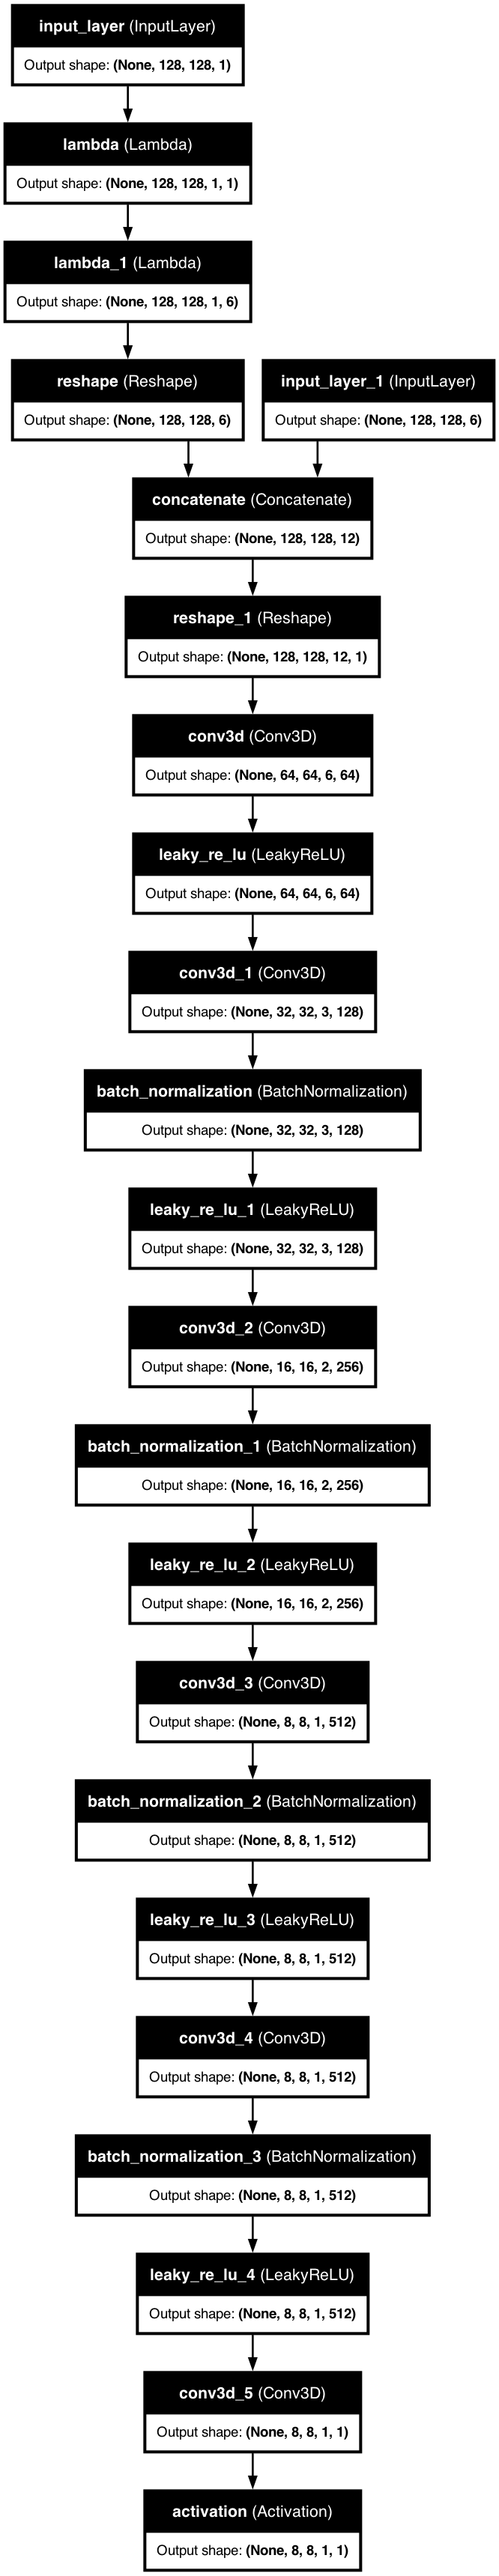

In [4]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf


tf.keras.utils.plot_model(
    model,
    to_file="discriminator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [5]:
from tensorflow.keras.losses import Loss
from tensorflow.image import ssim
import tensorflow as tf

class SSIMLoss(Loss):
    def __init__(self, max_val=1.0, **kwargs):
        super().__init__(**kwargs)
        self.max_val = max_val

    def call(self, y_true, y_pred):
        return 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=self.max_val))

    def get_config(self):
        config = super().get_config()
        config.update({"max_val": self.max_val})
        return config


tf.keras.utils.get_custom_objects()['SSIMLoss'] = SSIMLoss



# U-Net Generator

In [6]:
# defining the u-net encoder-decoder generator model
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
#from keras.utils.vis_utils import plot_model

# encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # batch normalization
    g = BatchNormalization()(g, training=True)
    # dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# standalone generator model
def define_generator(image_shape=(128, 128, 1), output_channels = 6):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    
    # bottleneck
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(e6)
    b = Activation('relu')(b)
    
    # decoder model
    d1 = decoder_block(b, e6, 512)
    d2 = decoder_block(d1, e5, 512)
    d3 = decoder_block(d2, e4, 512)
    d4 = decoder_block(d3, e3, 256, dropout=False)
    d5 = decoder_block(d4, e2, 128, dropout=False)
    d6 = decoder_block(d5, e1, 64, dropout=False)
    # output
    out_image = Conv2DTranspose(output_channels, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(d6)
    
    # model
    model = Model(in_image, out_image)
    ssim_loss = SSIMLoss(max_val=1.0)
    model.compile(optimizer='adam', loss=ssim_loss)
    return model

# image shape
image_shape = (128, 128, 1)

output_channels = 6

model = define_generator(image_shape, output_channels)

model.summary()


/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,088 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    131,200 │ leaky_re_lu_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    524,544 │ leaky_re_lu_6[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 4, 4, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 2, 2, 512) │  4,194,816 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 2, 2, 512) │          0 │ batch_normalizat

 Total params: 41,845,382 (159.63 MB)

 Trainable params: 41,837,574 (159.60 MB)

 Non-trainable params: 7,808 (30.50 KB)

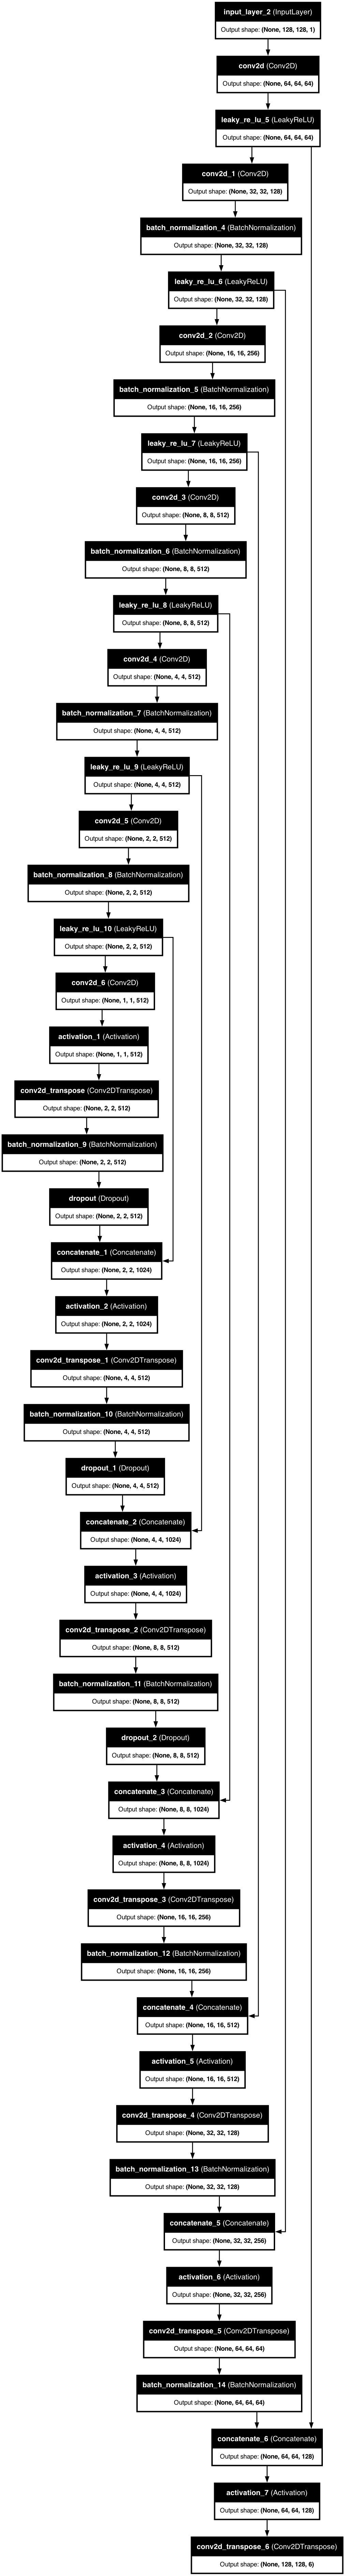

In [7]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf


tf.keras.utils.plot_model(
    model,
    to_file="generator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)

In [8]:

# combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    # source image
    in_src = Input(shape=image_shape)
    # connecting the source image to the generator input
    gen_out = g_model(in_src)
    # connecting the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
   
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    ssim_loss = SSIMLoss(max_val=1.0)
    model.compile(loss = ['binary_crossentropy', ssim_loss], optimizer=opt, loss_weights = [1,100])
    return model

In [9]:
custom_objects = {'SSIMLoss': SSIMLoss}

/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 128, 128,  │ 41,845,382 │ input_layer_6[0]… │
│ (Functional)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 8, 8, 1,   │ 27,831,233 │ input_layer_6[0]… │
│ (Functional)        │ 1)                │            │ functional_7[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,676,615 (265.80 MB)

 Trainable params: 69,665,991 (265.75 MB)

 Non-trainable params: 10,624 (41.50 KB)

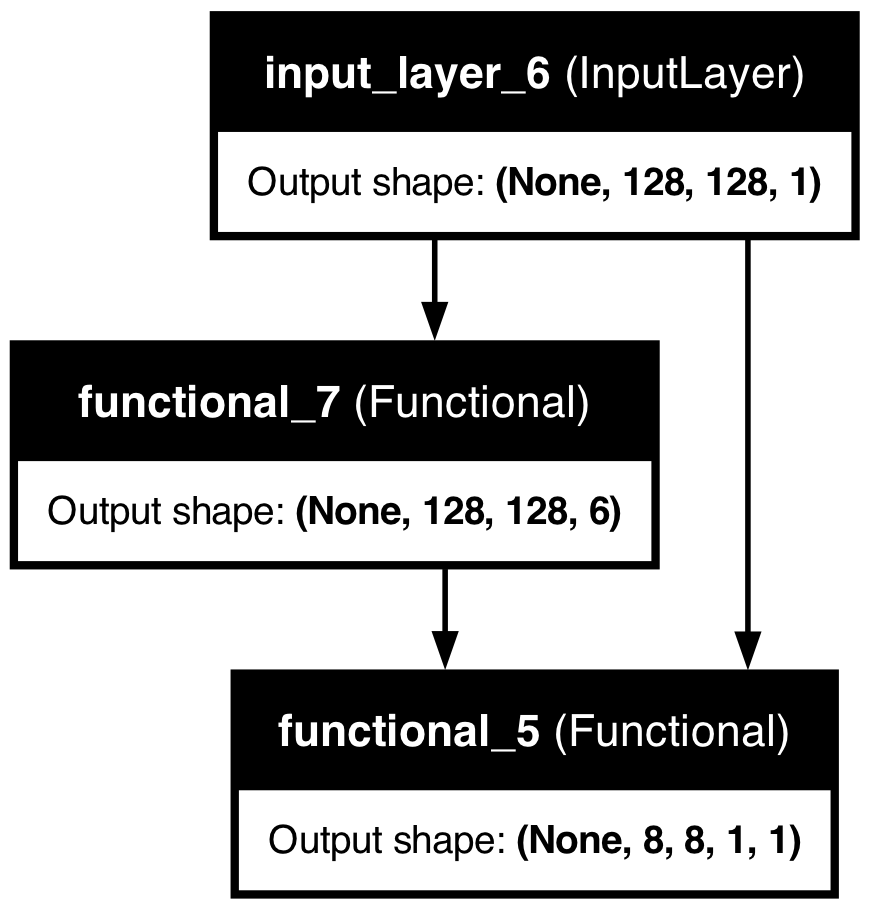

In [10]:
# image shape
image_shape = (128, 128, 1)
output_shape_3d = (128, 128, 6)
# defining the models
d_model = define_discriminator(image_shape, output_shape_3d)
g_model = define_generator(image_shape)
# defining the composite model
gan_model = define_gan(g_model, d_model, image_shape)

gan_model.summary()
# plotting the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

# Updating the model weights

In [11]:

import numpy as np
from numpy.random import randint
from numpy import ones
from numpy import zeros
import tensorflow as tf

def split_dataset(dataset):
    
    """
    # Check the dimensions of the dataset
    if dataset.shape != (2000, 128, 128, 7):
        raise ValueError('Dataset dimensions do not match the expected shape ', dataset.shape)
        
    """
    
    
    # Extracting the brightfield images (channel 0)
    brightfield_images = dataset[:, :, :, 0]

    # Extracting the fluorescence images (channels 1-6)
    fluorescence_images = dataset[:, :, :, 1:7]

    # Verifying the shapes
    print("Brightfield images shape:", brightfield_images.shape)  # Should be (:, 128, 128)
    print("Fluorescence images shape:", fluorescence_images.shape)  # Should be (:, 128, 128, 6)

    return brightfield_images, fluorescence_images



In [12]:
# selecting a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = split_dataset(dataset)
    print('trainA shape:', trainA.shape)
    print('trainB shape:', trainB.shape)
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [13]:
# generating a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape): 
    # Ensure samples are in channels_last format

    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X),patch_shape, patch_shape, 1))
    return X, y

In [14]:
def brightfield_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 0]
        if(np.min(img) <minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)

    return [minimum_value, maximum_value] 

def channel1_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 1]
        if(np.min(img) <minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]


def channel2_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 2]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)

    return [minimum_value, maximum_value]

def channel3_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 3]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel4_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 4]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel5_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 5]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel6_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 6]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def normalization_process(image, min_val, max_val):
    image = (((image.astype(np.float32) - min_val) / (max_val - min_val)) * 65535).astype(np.float32)
    image = (image.astype(np.float32)/ 65535).astype(np.float32)
    return image

In [15]:
def normalization_of_images(images_dataset):
    
    minimum_value_bf =  np.min(images_dataset[:, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[:, :, :, 0])
    
    minimum_value_1 =  np.min(images_dataset[:, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[:, :, :, 1])
    
    minimum_value_2 =  np.min(images_dataset[:, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[:, :, :, 2])
    
    minimum_value_3 =  np.min(images_dataset[:, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[:, :, :, 3])
    
    minimum_value_4 =  np.min(images_dataset[:, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[:, :, :, 4])
    
    minimum_value_5 =  np.min(images_dataset[:, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[:, :, :, 5])

    minimum_value_6 =  np.min(images_dataset[:, :, :, 6])  
    maximum_value_6 = np.max(images_dataset[:, :, :, 6])
    
    
    minimum_value_bf, maximum_value_bf =  brightfield_images(minimum_value_bf, maximum_value_bf, images_dataset) 
    minimum_value_1, maximum_value_1 =  channel1_images(minimum_value_1, maximum_value_1, images_dataset) 
    minimum_value_2, maximum_value_2 =  channel2_images(minimum_value_2, maximum_value_2, images_dataset) 
    minimum_value_3, maximum_value_3 =  channel3_images(minimum_value_3, maximum_value_3, images_dataset) 
    minimum_value_4, maximum_value_4 =  channel4_images(minimum_value_4, maximum_value_4, images_dataset) 
    minimum_value_5, maximum_value_5 =  channel5_images(minimum_value_5, maximum_value_5, images_dataset) 
    minimum_value_6, maximum_value_6 =  channel6_images(minimum_value_6, maximum_value_6, images_dataset) 
    
   
    
    
    for i in range(images_dataset.shape[0]):
        for j in range(images_dataset.shape[-1]):
            if(j==0):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_bf, maximum_value_bf)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==1):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_1)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==2):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_2)
                images_dataset[i, :, :, j] = temp_image
            
            if(j==3):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_3)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==4):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_4)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==5):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_5)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==6):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_6)
                images_dataset[i, :, :, j] = temp_image
            
        

    
    """"
                
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 
    
    print("minimum value in channel 6 of images = ", minimum_value_6)
    print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    print("shape of normalized images dataset = ", images_dataset.shape)
    #print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    """
    
    return images_dataset
    

In [16]:
def min_and_max_images(images_dataset):    
    minimum_value_bf =  np.min(images_dataset[:, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[:, :, :, 0])

    minimum_value_1 =  np.min(images_dataset[:, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[:, :, :, 1])

    minimum_value_2 =  np.min(images_dataset[:, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[:, :, :, 2])

    minimum_value_3 =  np.min(images_dataset[:, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[:, :, :, 3])

    minimum_value_4 =  np.min(images_dataset[:, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[:, :, :, 4])

    minimum_value_5 =  np.min(images_dataset[:, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[:, :, :, 5])

    minimum_value_6 =  np.min(images_dataset[:, :, :, 6])  
    maximum_value_6 = np.max(images_dataset[:, :, :, 6])
    
    """              
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 
    
    print("minimum value in channel 6 of images = ", minimum_value_6)
    print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    print("shape of normalized images dataset = ", images_dataset.shape)
    """

In [17]:

# Example model compilation for multiple outputs
d_model.compile(optimizer='Adam', loss='binary_crossentropy')
d_model.trainable = True



In [18]:

from keras.optimizers import SGD
 
opt = Adam(learning_rate=0.0002)
ssim_loss = SSIMLoss(max_val=1.0)
gan_model.compile(loss=['binary_crossentropy', ssim_loss], optimizer=opt, loss_weights=[1, 100])



In [19]:
import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

class CustomModelCheckpoint(Callback):
    def __init__(self, g_model, d_model, gan_model, filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1):
        super(CustomModelCheckpoint, self).__init__()
        self.g_model = g_model
        self.d_model = d_model
        self.gan_model = gan_model
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0
        self.best = float('inf') if mode == 'min' else float('-inf')
        self.monitor_op = np.less if mode == 'min' else np.greater
        if mode not in ['auto', 'min', 'max']:
            mode = 'auto'
        if mode == 'min':
            self.monitor_op = np.less
            self.best = float('inf')
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = float('-inf')
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = float('-inf')
            else:
                self.monitor_op = np.less
                self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            current = logs.get(self.monitor)
            if isinstance(current, list):
                current = current[0]  # Assuming the first value is what you want
            if current is None:
                warnings.warn(f'Can save best model only with {self.monitor} available, skipping.', RuntimeWarning)
            else:
                if self.save_best_only:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} improved from {self.best:.5f} to {current:.5f}, saving model to {self.filepath}')
                        self.best = current
                        self._save_model(self.filepath.format(epoch=epoch + 1, val_loss=current), overwrite=True)
                    else:
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} did not improve from {self.best:.5f}')
                else:
                    if self.verbose > 0:
                        print(f'\nEpoch {epoch + 1}: saving model to {self.filepath}')
                    self._save_model(self.filepath.format(epoch=epoch + 1, val_loss=current), overwrite=True)

    def _save_model(self, filepath, overwrite=True):
        if self.save_weights_only:
            self.g_model.save_weights(filepath + '_generator.h5', overwrite=overwrite)
            self.d_model.save_weights(filepath + '_discriminator.h5', overwrite=overwrite)
            self.gan_model.save_weights(filepath + '_gan.h5', overwrite=overwrite)
        else:
            self.g_model.save(filepath + '_generator.keras', overwrite=overwrite)
            self.d_model.save(filepath + '_discriminator.keras', overwrite=overwrite)
            self.gan_model.save(filepath + '_gan.keras', overwrite=overwrite)

In [20]:
import os
import shutil

"""
# Clear previous checkpoints
checkpoint_dir = 'checkpoints'
if os.path.exists(checkpoint_dir):
    print("checkpoint directory exists")
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)
"""

'\n# Clear previous checkpoints\ncheckpoint_dir = \'checkpoints\'\nif os.path.exists(checkpoint_dir):\n    print("checkpoint directory exists")\n    shutil.rmtree(checkpoint_dir)\nos.makedirs(checkpoint_dir)\n'

In [21]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import glob

checkpoint_dir = 'checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)

In [22]:
latest_checkpoint = None

# Find the latest checkpoint file for each model
generator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_generator.keras'))
discriminator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_discriminator.keras'))
gan_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_gan.keras'))

if generator_checkpoints and discriminator_checkpoints and gan_checkpoints:
    latest_generator = max(generator_checkpoints, key=os.path.getctime)
    latest_discriminator = max(discriminator_checkpoints, key=os.path.getctime)
    latest_gan = max(gan_checkpoints, key=os.path.getctime)
    
    print(f"Found checkpoints:\nGenerator: {latest_generator}\nDiscriminator: {latest_discriminator}\nGAN: {latest_gan}")
    latest_checkpoint = True
else:
    print("No complete set of checkpoints found. Starting from scratch.")
    latest_checkpoint = None

Found checkpoints:
Generator: checkpoints/model_checkpoint_20_12.14_generator.keras
Discriminator: checkpoints/model_checkpoint_20_12.14_discriminator.keras
GAN: checkpoints/model_checkpoint_20_12.14_gan.keras


In [23]:
input_shape_2d = (128, 128, 1)
output_shape_3d = (128, 128, 6)
image_shape = (128, 128, 1)


In [24]:
import os
import tensorflow as tf

starting_epoch = 0
if latest_checkpoint:
    print("Loading weights from checkpoints...")
    try:
        # Load weights for each model separately
        g_model.load_weights(latest_generator)
        d_model.load_weights(latest_discriminator)
        gan_model.load_weights(latest_gan)
        epoch_str = os.path.basename(latest_generator).split('_')[2]
        starting_epoch = int(epoch_str)
        print(f"Resuming from epoch {starting_epoch}")
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {str(e)}")
        print("Initializing models with random weights.")
        # If loading fails, we'll start with fresh models
        g_model = define_generator(image_shape)
        d_model = define_discriminator(input_shape_2d, output_shape_3d)
        gan_model = define_gan(g_model, d_model, image_shape)

# Creating the custom checkpoint callback
custom_checkpoint = CustomModelCheckpoint(
    g_model=g_model,
    d_model=d_model,
    gan_model=gan_model,
    filepath=os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}_{val_loss:.2f}'),
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    period=20
)


Loading weights from checkpoints...
Error loading weights: File is not a zip file
Initializing models with random weights.


/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [25]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path, batch_size, patch_shape, generator_model):
        
        self.file_path = file_path
        self.batch_size = batch_size
        self.patch_shape = patch_shape
        
        self.data = np.load(file_path)['array']
        if(flag == 1):
            self.data = self.data[4000:4500]
        else:
            self.data = self.data[:2000]
        print(self.data.shape)
        
        # Normalization
        self.data = normalization_of_images(self.data)

        self.indices = np.arange(self.data.shape[0])
        self.generator_model = generator_model
        self.trainA, self.trainB = split_dataset(self.data)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.trainA) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Generating data
        X_realA, X_realB, y_real, X_fakeB, y_fake = self.__data_generation(indexes)
        return [X_realA, X_realB], [y_real, X_fakeB, y_fake]


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.trainA))
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # Generating real samples
        X_realA, X_realB = self.trainA[indexes], self.trainB[indexes]
        y_real = np.ones((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
        # Generating fake samples
        X_fakeB = self.generator_model.predict(X_realA)
        y_fake = np.zeros((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
    
        
        return X_realA, X_realB, y_real, X_fakeB, y_fake


In [26]:
import tensorflow as tf

def calculate_ssim_loss(real_images, generated_images):
    
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
    generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)
    
    # Calculating SSIM scores
    ssim_scores = tf.image.ssim(real_images, generated_images, max_val=1.0)
    
    # Calculating mean SSIM score
    mean_ssim = tf.reduce_mean(ssim_scores)
    
    # Converting SSIM to loss (1 - SSIM)
    ssim_loss = 1 - mean_ssim
    
    return ssim_loss


In [27]:
import os

file_path = 'fluor_images_transposed_asnumpy.npz'
if os.path.exists(file_path):
    print(f"File found: {file_path}")
    data = np.load(file_path)
else:
    print(f"File not found: {file_path}")
    

File found: fluor_images_transposed_asnumpy.npz


# Training

In [28]:
flag = 0

In [29]:

batch_size = 32  # batch size
patch_shape = 8  # patch shape
 
epochs = 50

data_gen = DataGenerator('fluor_images_transposed_asnumpy.npz', batch_size, patch_shape, g_model)


# Training loop
for epoch in range(starting_epoch, epochs):
    for batch in range(len(data_gen)):
        [X_realA, X_realB], [y_real, X_fakeB, y_fake] = data_gen[batch]
        
        # Training the discriminator
        d_loss_real = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss_fake = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Training the generator
        g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        
        # Calculating SSIM loss
        ssim_loss = calculate_ssim_loss(X_realB, X_fakeB)
        
        print(f'Epoch {epoch+1}, Batch: {batch+1}, SSIM Loss: {ssim_loss}')
        
      
        
    custom_checkpoint.on_epoch_end(epoch, logs={'val_loss': g_loss})
    # Clearing the Keras session
    tf.keras.backend.clear_session()

custom_checkpoint.on_train_end(logs={})

(2000, 128, 128, 7)
Brightfield images shape: (2000, 128, 128)
Fluorescence images shape: (2000, 128, 128, 6)


2024-09-02 11:29:06.026224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1, Batch: 1, SSIM Loss: 0.8605568408966064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 1, Batch: 2, SSIM Loss: 0.8275985717773438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1, Batch: 3, SSIM Loss: 0.78433758020401
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 1, Batch: 4, SSIM Loss: 0.759455680847168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 1, Batch: 5, SSIM Loss: 0.7580779790878296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 1, Batch: 6, SSIM Loss: 0.7157405018806458
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1, Batch: 7, SSIM Loss: 0.7002975940704346
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1, Batch: 8, SSIM Loss: 0.6594260931015015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1, Batch: 9, SSIM Loss: 0.6432582139968872
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1, Batch: 10, SSIM Loss: 0.5915929079055786
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch 1, Batch: 11, SSIM Loss: 0.5671273469924927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1,

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20, 20))
print(X_realB.shape)
for j in range(X_realB.shape[-1]):
    img = X_fakeB[5,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()

In [ ]:

plt.figure(figsize=(20, 20))
print(X_fakeB.shape)
for j in range(X_fakeB.shape[-1]):
    img = X_fakeB[5,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()


# Validation

In [ ]:
flag = 1

In [ ]:
batch_size = 32
patch_shape = 8  

data_gen_validation = DataGenerator('fluor_images_transposed_asnumpy.npz', batch_size, patch_shape, g_model)

d_losses_real = []
d_losses_fake = []
g_losses = []

In [ ]:
[X_realA_val, X_realB_val], [y_real_val, X_fakeB_val, y_fake_val] = data_gen_validation[1]

In [ ]:
print("X_realA_val: ", X_realA_val.shape)
print("X_realB_val", X_realB_val.shape)
print("X_fakeB_val", X_fakeB_val.shape)
print("y_real_val", y_real_val.shape)
print("y_fake_val", y_fake_val.shape)


In [ ]:


for batch in range(0, len(data_gen_validation), batch_size):
    [X_realA_val, X_realB_val], [y_real_val, X_fakeB_val, y_fake_val] = data_gen_validation[batch]

    
    d_loss_real = d_model.test_on_batch([X_realA_val, X_realB_val], y_real_val)
    d_loss_fake = d_model.test_on_batch([X_realA_val, X_fakeB_val], y_fake_val)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_losses_real.append(d_loss_real)
    d_losses_fake.append(d_loss_fake)

    
    g_loss = gan_model.test_on_batch(X_realA_val, [y_real_val, X_realB_val])
    g_losses.append(g_loss)

    # Calculating  Validation SSIM loss
    ssim_loss = calculate_ssim_loss(X_realB_val, X_fakeB_val)

    print(f'Batch: {batch+1}, SSIM Loss: {ssim_loss}')
    
      
        
    
    # Clearing the Keras session
    tf.keras.backend.clear_session()



In [ ]:
plt.figure(figsize=(20, 20))
print(X_fakeB_val.shape)
for j in range(X_fakeB_val.shape[-1]):
    img = X_fakeB_val[22,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()